In [ ]:
##########                       MERGING/DATA CLEANING              #########


######---------------------------IMPORTING----------------------------------------------------

import pandas as pd

games_raw = pd.read_csv("data/games.csv")
players_raw = pd.read_csv("data/players.csv")
stats_raw = pd.read_csv("data/stats.csv")



######---------------------------INITIAL DATA EXPLORATION--------------------------------------

print(">>>>>>>>>>>>>>PLAYERS<<<<<<<<<<<<")
display(games_raw.head(2))
print("")
display(games_raw.tail(2))
print("")
display(games_raw.info())
print("")

print(">>>>>>>>>>>>>>PLAYERS<<<<<<<<<<<<")
display(players_raw.head(2))
print("")
display(players_raw.tail(2))
print("")
display(players_raw.info())
print("")

print(">>>>>>>>>>>>>>STATS<<<<<<<<<<<<")
display(stats_raw.head(2))
print("")
display(stats_raw.tail(2))
print("")
display(stats_raw.info())
print("")



######--------------------------REMOVING UNNECESSARY COLUMNS---------------------------------------

### Only columns relevant to the current analysis were kept
games_data = games_raw.drop(columns = ["homeTeam", "rainfall", "date", "startTime", "attendance", "homeTeamScore", "awayTeam","awayTeamScore"])

players_data = players_raw.drop(columns = ["height", "weight", "dob", "origin"])

stats_data = stats_raw.drop(columns = ["team", "Inside 50s", "Contested Possessions", "Uncontested Possessions", "year", "round", "displayName", "Hit Outs", "Tackles", "Rebounds", "Clearances", "Clangers", "Frees", "Frees Against", "Brownlow Votes", "Contested Marks", "Marks Inside 50", "One Percenters", "Bounces", "Goal Assists", "% Played", "Subs", "Marks"])



######-----------------------NORMALISING DATA TYPES---------------------------------------

### PlayerID was converted to int to allow for easier merging 
players_data["playerId"]=players_data["playerId"].astype(int)

stats_data["playerId"]=stats_data["playerId"].astype(int)



######--------------------------MERGING TABLES----------------------------------------------
# Fact table (stats) was used as the left table in these merges. Dimension tables (players,
# games) were used as right table in these merges. 
players_stats_raw = stats_data.merge(how='left', left_on='playerId', right=players_data, right_on='playerId')

complete_stats_raw = players_stats_raw.merge(how='left', left_on='gameId', right=games_data, right_on = 'gameId')



######------------------CLEANING DATA I: REMOVING DUPLICATES----------------------------------

# Duplicates were removed to ensure that each entry for a specific player in a specific 
# game is unique 
stats_cleaned1 = complete_stats_raw.drop_duplicates(subset=['gameId', 'playerId'], keep="first")



######--------------CLEANING DATA II: HANDLING ZERO/MISSING VALUES---------------------------


### Check for null values
mask_null = stats_cleaned1.isnull()
display(mask_null.sum())

### Check for NA values 
mask_na = stats_cleaned1.isna()
display(mask_na.sum())

### Check for zero values in columns
for column_name in stats_cleaned1.columns:
    zero_values = stats_cleaned1[column_name] == 0
    display("------" + column_name + "-------")
    print(zero_values.sum())

### No Null, NA or zero values found, no further cleaning necessary



######--------------CLEANING DATA III: FINISHING TOUCHES------------------------------


### 1- Remove ID columns (no longer needed now that the merge is complete)
stats_cleaned2 = stats_cleaned1.drop(columns = ["gameId", "playerId"])

### 2- Reorder columns
stats_cleaned3 = stats_cleaned2.loc[:, ["year", "round", "displayName", "position", "gameNumber", "Disposals", "Kicks", "Handballs", "Goals", "Behinds",]]

### 3- Replace QF, SF etc with R24, R25 etc. 
stats_cleaned3['Round_new'] = stats_cleaned3['round'].replace(['QF', 'EF', 'SF', 'PF', 'GF'], ['R24', 'R24', 'R25', 'R26', 'R27'])
stats_cleaned4 = stats_cleaned3.drop(columns = ['round'])

### 4- Rename columns
stats_cleaned5 = stats_cleaned4.rename(columns={"year" : "Year", "Round_new":"Round", "displayName":"Player Name", "position":"Position", "gameNumber":"Game Number"})

### 5- Remove "R" in Rounds column
stats_cleaned5['Round Number'] = list(map(lambda i: i[1:], stats_cleaned5['Round']))
stats_cleaned6 = stats_cleaned5.drop(columns = ['Round'])


### 6- Reorder rows chronologically
stats_cleaned6['Round Number']=stats_cleaned6['Round Number'].astype(int)
stats_new_index = stats_cleaned6.set_index(['Year', "Round Number"])
reordered_stats = stats_new_index.sort_values(['Year', "Round Number"])
stats = reordered_stats
# display(stats)


>>>>>>>>>>>>>>PLAYERS<<<<<<<<<<<<


,gameId,year,round,date,venue,startTime,attendance,homeTeam,homeTeamScore,awayTeam,awayTeamScore,rainfall
0,2021R101,2021,R1,18-Mar-2021,M.C.G.,7:25 PM,49218,Richmond,105,Carlton,80,0.0
1,2021R102,2021,R1,19-Mar-2021,M.C.G.,7:50 PM,46051,Collingwood,53,Western Bulldogs,69,0.0


,gameId,year,round,date,venue,startTime,attendance,homeTeam,homeTeamScore,awayTeam,awayTeamScore,rainfall
2022,2012PF02,2012,PF,22-Sep-2012,M.C.G.,5:15 PM,69146,Hawthorn,97,Adelaide,92,1.0
2023,2012GF01,2012,GF,29-Sep-2012,M.C.G.,2:30 PM,99683,Hawthorn,81,Sydney,91,8.4



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gameId         2024 non-null   object 
 1   year           2024 non-null   int64  
 2   round          2024 non-null   object 
 3   date           2024 non-null   object 
 4   venue          2024 non-null   object 
 5   startTime      2024 non-null   object 
 6   attendance     2024 non-null   int64  
 7   homeTeam       2024 non-null   object 
 8   homeTeamScore  2024 non-null   int64  
 9   awayTeam       2024 non-null   object 
 10  awayTeamScore  2024 non-null   int64  
 11  rainfall       1993 non-null   float64
dtypes: float64(1), int64(4), object(7)
memory usage: 189.9+ KB


None


>>>>>>>>>>>>>>PLAYERS<<<<<<<<<<<<


,playerId,displayName,height,weight,dob,position,origin
0,2021661124,"Berry, Sam",181,81,12-Feb-2002,"Midfield, Forward",Gippsland Power
1,2012662083,"Brown, Luke",181,81,22-Sep-1992,Defender,Norwood


,playerId,displayName,height,weight,dob,position,origin
1493,2005833394,"Sherman, Justin",183,89,26-Jan-1987,"Midfield, Forward",Clarence
1494,2011838967,"Skinner, Zephaniah",189,79,27-Jun-1989,Forward,-



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495 entries, 0 to 1494
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   playerId     1495 non-null   int64 
 1   displayName  1495 non-null   object
 2   height       1495 non-null   int64 
 3   weight       1495 non-null   int64 
 4   dob          1495 non-null   object
 5   position     1495 non-null   object
 6   origin       1491 non-null   object
dtypes: int64(3), object(4)
memory usage: 81.9+ KB


None


>>>>>>>>>>>>>>STATS<<<<<<<<<<<<


,gameId,team,year,round,playerId,displayName,gameNumber,Disposals,Kicks,Marks,...,Brownlow Votes,Contested Possessions,Uncontested Possessions,Contested Marks,Marks Inside 50,One Percenters,Bounces,Goal Assists,% Played,Subs
0,2021R104,Adelaide,2021,R1,2021661124,"Berry, Sam",1,8,6,1,...,0,4,5,0,0,0,0,1,80,-
1,2021R104,Adelaide,2021,R1,2012662083,"Brown, Luke",168,5,2,0,...,0,2,3,0,0,0,0,0,23,Off


,gameId,team,year,round,playerId,displayName,gameNumber,Disposals,Kicks,Marks,...,Brownlow Votes,Contested Possessions,Uncontested Possessions,Contested Marks,Marks Inside 50,One Percenters,Bounces,Goal Assists,% Played,Subs
89468,2012R2309,Western Bulldogs,2012,R23,2011872415,"Wallis, Mitch",25,19,8,2,...,0,9,11,0,0,2,0,0,83,-
89469,2012R2309,Western Bulldogs,2012,R23,2009879614,"Wood, Easton",42,20,13,11,...,0,2,18,0,0,3,1,0,89,-



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89470 entries, 0 to 89469
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   gameId                   89470 non-null  object
 1   team                     89470 non-null  object
 2   year                     89470 non-null  int64 
 3   round                    89470 non-null  object
 4   playerId                 89470 non-null  int64 
 5   displayName              89470 non-null  object
 6   gameNumber               89470 non-null  int64 
 7   Disposals                89470 non-null  int64 
 8   Kicks                    89470 non-null  int64 
 9   Marks                    89470 non-null  int64 
 10  Handballs                89470 non-null  int64 
 11  Goals                    89470 non-null  int64 
 12  Behinds                  89470 non-null  int64 
 13  Hit Outs                 89470 non-null  int64 
 14  Tackles                  89470 non-nu

None

gameId         0
playerId       0
gameNumber     0
Disposals      0
Kicks          0
Handballs      0
Goals          0
Behinds        0
displayName    0
position       0
year           0
round          0
venue          0
dtype: int64

gameId         0
playerId       0
gameNumber     0
Disposals      0
Kicks          0
Handballs      0
Goals          0
Behinds        0
displayName    0
position       0
year           0
round          0
venue          0
dtype: int64

'------gameId-------'

0


'------playerId-------'

0


'------gameNumber-------'

0


'------Disposals-------'

302


'------Kicks-------'

676


'------Handballs-------'

1544


'------Goals-------'

58707


'------Behinds-------'

63341


'------displayName-------'

0


'------position-------'

0


'------year-------'

0


'------round-------'

0


'------venue-------'

0


The above has generated a clean, unified dataset (stats) which can now be used for analysis. 

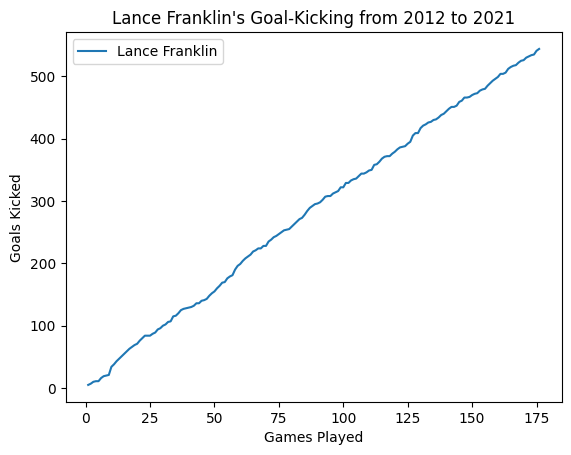

In [2]:
##########           PLOTTING ONE PLAYER (LANCE "BUDDY" FRANKLIN)          #########

### Filtering total data to only include buddy's stats
buddy_stats = pd.DataFrame(stats[stats["Player Name"] == "Franklin, Lance"])

### Reformatting games played to start from 1 
buddy_stats["Games Played"] = (buddy_stats["Game Number"]) - 142

### Creating a running total goals column
buddy_stats["Total Goals"] = buddy_stats["Goals"].cumsum()

### Plotting Buddy's goals over time
buddy_plot = buddy_stats.plot(kind='line', x='Games Played', xlabel = "Games Played", y='Total Goals', ylabel = "Goals Kicked", legend=True, label = "Lance Franklin", title = "Lance Franklin's Goal-Kicking from 2012 to 2021")

The above plot shows us the progression of Lance "Buddy" Franklin's total goals over his career, between the years of 2012 and 2021. 
Notably, it is immediately noticeable that this line is very straight, with little deviation. This indicates an incredible consistency in Buddy's goalkicking. We can also see from the steepness of the line that he kicks a lot of goals. By "eyeballing" the chart we can see that Buddy averages approximately 3 goals per game over the entire stretch from 2012-2021.
From watching AFL consistently, I can say with certainty that a CONSISTENT 3 goal average over hundreds of games is a remarkable feat that few have every achieved.  

<Axes: xlabel='Games Played', ylabel='Goals Kicked'>

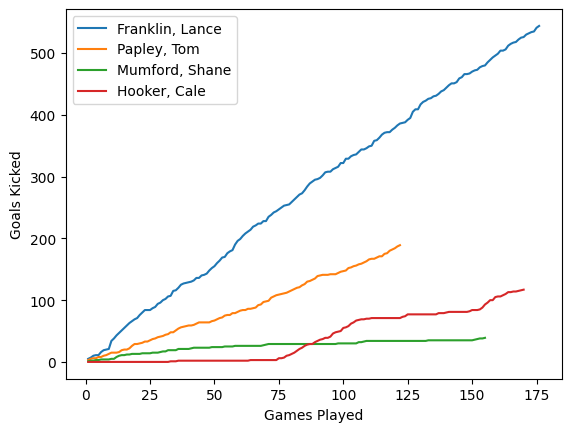

In [3]:
##########               PLOTTING MULTIPLE PLAYERS               #########


### Create blank canvas
ax = pd.Series([] ,dtype = int).plot(color="purple")

### Define players to analyse
player_list = ["Franklin, Lance", "Papley, Tom", "Mumford, Shane", "Hooker, Cale"]

### Create loop to plot each player in 'player_list'
for p in player_list: 
    p_stats = pd.DataFrame(stats[stats["Player Name"] == p])
    p_stats["Games Played"] = (p_stats["Game Number"] - p_stats["Game Number"].min()) +1
    p_stats["Total Goals"] = p_stats["Goals"].cumsum()
    p_plot = p_stats.plot(kind="line", x = "Games Played", xlabel = "Games Played", y="Total Goals", ylabel = "Goals Kicked", ax=ax, label = p, legend = True)
    

display(ax)


The above chart shows the plot of four players goal kicking between 2012 and 2021. 

First impressions tell us that the player plotted in orange (Tom Papley) had remarkably fewer games played than others. Upon reviewing the data, it can be found that data for Tom Papley begins in 2016, in line with his AFL debut. The other players are older and were thus playing continuously from 2012 onwards. The discrepancy in total games played can be attributed to injuries over the years. 

Next, there is a noticable difference in the shape of the line drawn for Cale "Hooksy" Hooker. There is a marked increase in the slop of the line between game ~75 and ~105 and again from game ~155 onwards. Cale Hooker was a key forward/defender in his career. The periods in which he kicked many goals would represent the periods where he played in the forward line whereas the flat periods would represent his time as a defender. 

Lastly, of the remaining three plotted lines, all have notably different gradients. This can be attributed to multiple factors: 
- Shane Mumford played in the ruck for most of his career, typically not a big goal scoring position.
- Tom Papley plays as a small forward, explaining why he kicks goals consistently and significantly more than Mumford.
- Buddy Franklin was a key forward, and one of the best of all time, explaining why the gradient for his line is much steeper. 

<Axes: xlabel='Games Played', ylabel='Goals Kicked'>

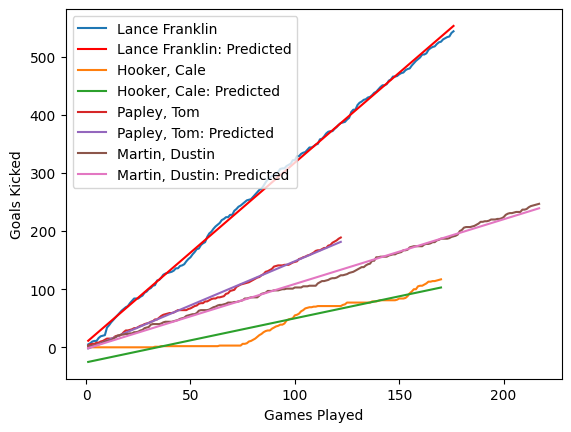

In [4]:
##########                PLOTTING PLAYERS PREDICTED GOALS         #########

import numpy as np 

##Finding the Coefficients
buddy_coef = np.polyfit(buddy_stats["Games Played"], buddy_stats["Total Goals"],1)

##Finding the formula of the prediction line
buddy_line = np.poly1d(buddy_coef)
# display(buddy_line(100))

## Creating a predicted goals column 
buddy_stats["Prediction"] = buddy_line(buddy_stats["Games Played"])

## Plotting Buddy's goals along with his predicted goals (canvas)
canvas = buddy_stats.plot(kind="line", x="Games Played", y='Total Goals', legend=True, label = "Lance Franklin")
buddy_prediction_plot = buddy_stats.plot(kind='line', x='Games Played', y='Prediction', label="Lance Franklin: Predicted", color='Red', ax=canvas)

## Define players to analyse
player_list = ["Hooker, Cale", "Papley, Tom", "Martin, Dustin"]


##Create loop to calculate and plot predicted goals for players in 'player_list'
for p in player_list: 
    ## Filter dataset
    p_stats = pd.DataFrame(stats[stats["Player Name"] == p])
    ## Reset games played to start at 1
    p_stats["Games Played"] = (p_stats["Game Number"] - p_stats["Game Number"].min()) +1
    ## Create a running 'Total goals' column
    p_stats["Total Goals"] = p_stats["Goals"].cumsum()
    ## Plot actual goals 
    p_plot = p_stats.plot(kind="line", x = "Games Played", xlabel = "Games Played", y="Total Goals", ylabel = "Goals Kicked", ax=canvas, label = p, legend = True)
    ## Calculate player coefficients
    p_coef = np.polyfit(p_stats["Games Played"], p_stats["Total Goals"], 1)
    ## Fit a line with those coefficients
    p_line = np.poly1d(p_coef)
    ## Create a predicted goals column
    p_stats["Prediction"] = p_line(p_stats["Games Played"])
    ## Plot prediction on original chart (canvas)
    p_prediction_plot = p_stats.plot(kind='line', x="Games Played", y='Prediction', label = (p + ": Predicted"), legend=True, ax=canvas)

canvas  



In the above chart we can see the plotted goals kicked between 2012 and 2021 for two players, as well as the predicted goals. 

Buddy Franklin is a remarkably consistent goalscorer and the actual goals plot stays quite close to the prediction line throughout the whole timeframe. The slope of the line is 3.17 indicating that Buddy kicked an average of 3+ goals per game in the given timeframe. 

Cale Hooker on the other hand changed positions multiple times throughout his career, switching between key forward and defender roles. The flat periods represent his time as a defender while the steeper sections represent his time as a key forward. Due to this inconsistency, the actual goals plot deviates from the predicted goals plot a lot during his career. Notably, the predicted goals line starts in the negatives, which is of course infeasable and indicates that some adjustment may need to be made to create a "realistic line of best fit" for this player. The slope of the line is 0.75 indicating that Hooker averaged less than a goal per game. However, given that this line starts from -25 the real value for his expected goals is likely  higher.